# Деревья классификации CART

**Выполнила:** Медведева Ольга Игоревна

**Вариант:** 2

**Данные:** default of credit card clients

**Задание:** 
- Построить модель для распознавания целевой переменной (отклика)
- Для распознавания использовать деревья классификации CART
- Выбрать критерии качества
- Обосновать выбор параметров модели

In [1]:
# Загружаю бибилотеки

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
# Импортирую данные

df = pd.read_excel('default of credit card clients.xls', index_col=0, skiprows=1)

df.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


Видно что таблица содержит 0 в столбцах X6 - X11 (PAY_0 	PAY_2 	PAY_3 	PAY_4 	PAY_5, PAY_6) с историей последних платежей, где возможные значения -1, 1, 2 и т.д в зависимости от срока выплаты. Очень важный параметр для принятия решения о выдаче кредита в банке и неверные значения могут сильно исказить результат. Поэтому попробую убрать из таблицы строки, в которых все эти значения одновременно равны нулю.

In [3]:
df = df.loc[(df['PAY_0'] != 0) & (df['PAY_2'] != 0) & (df['PAY_3'] != 0) & (df['PAY_4'] != 0) & (df['PAY_5'] != 0) & (df['PAY_6'] != 0)]

In [4]:
#  Проверяю размерность матрицы данных

df.shape

(8827, 24)

In [5]:
#  Классы сбалансированы?

df['default payment next month'].value_counts()

0    6438
1    2389
Name: default payment next month, dtype: int64

Количество экземпляров в классе 0 превышает количество экземпляров в классе 1 в 2,7 раза. Это много, но данных стало меньше после очистки, поэтому будем работать с таким распределением данных по классам.

In [6]:
df.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
10,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0
12,260000,2,1,2,51,-1,-1,-1,-1,-1,...,8517,22287,13668,21818,9966,8583,22301,0,3640,0
19,360000,2,1,1,49,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
20,180000,2,1,2,29,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
22,120000,2,2,1,39,-1,-1,-1,-1,-1,...,0,632,316,316,316,0,632,316,0,1
24,450000,2,1,1,40,-2,-2,-2,-2,-2,...,560,0,0,19428,1473,560,0,0,1128,1
27,60000,1,1,2,27,1,-2,-1,-1,-1,...,-57,127,-189,0,1000,0,500,0,1000,1
29,50000,2,3,1,47,-1,-1,-1,-1,-1,...,2040,30430,257,3415,3421,2044,30430,257,0,0


In [7]:
#  Разделяю предикоторы и отклики

X = df.iloc[:, :-1].values  
y = df.iloc[:, 23].values 

In [8]:
#  Проверяю себя

y

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

In [9]:
#  Разделяю на обучающую и тестовую выборку

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1234)

In [10]:
#  Задаю начальные параметры модели
#  Инициализирую модель

model = DecisionTreeClassifier(random_state=42,
                               criterion='entropy',
                               # максимальная глубина дерева
                               max_depth=6,
                               # максимальное число конечных узлов (сейчас - без ограничений)
                               max_leaf_nodes=None,
                               # минимальное число элементов в узле для разбиения (может быть долей)
                               min_samples_split=10,
                               # минимальное число элементов в потомке(может быть долей)
                               min_samples_leaf=8,
                               # минимальное значение уменьшения загрязнения (impurity)
                               min_impurity_decrease=0.001,
                               class_weight=None,
                               min_weight_fraction_leaf=0,
                               splitter='best',
                               max_features = None)

# Обучаю модель

model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6,
                       min_impurity_decrease=0.001, min_samples_leaf=8,
                       min_samples_split=10, min_weight_fraction_leaf=0,
                       random_state=42)

In [11]:
# Распознаю, используя дерево CART

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [12]:
# Распознаю вероятности принадлежать классам

y_pred_train2 = model.predict_proba(X_train)
y_pred_test2 = model.predict_proba(X_test)

In [13]:
# Предсказание класса для новых элементов

new_item = [6000, 1, 2, 1, 45, -1, 1, -1, -1, 1, 2, 4000, 3800, 3500, 2700, 2220, 1375, 1578, 1423, 1287, 1000, 980, 620]
model.predict([new_item])

array([1], dtype=int64)

Воспользуюсь методом feature_importances_ для оценки ценности каждого параметра данных в таблице.

In [14]:
pd.DataFrame({'feature': df.iloc[:, :-1].columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
6,PAY_2,0.625178
19,PAY_AMT3,0.109396
5,PAY_0,0.068191
11,BILL_AMT1,0.059350
17,PAY_AMT1,0.024435
0,LIMIT_BAL,0.020919
14,BILL_AMT4,0.020743
22,PAY_AMT6,0.019380
16,BILL_AMT6,0.016591
18,PAY_AMT2,0.016442


63% ценности имеет параметр PAY_2 - это второй платеж из истории платежей по кредиту. 11% ценности PAY_AMT3 - сумма третьего предыдущего платежа. Следующие 10 параметро имеют небольшие ценности. А еще 11 имеют нулевую ценность.

In [15]:
# Рассмотрю матрицы распределения по классам для обучающей выборки

conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,4015,308
1,898,693


In [16]:
# Рассмотрю матрицы распределения по классам для тестовой выборки

conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,1960,155
1,446,352


In [17]:
print("Accuracy on train set is ", accuracy_score(y_train, y_pred_train)*100)
print("Accuracy on test set is ", accuracy_score(y_test, y_pred_test)*100)

Accuracy on train set is  79.6077105174163
Accuracy on test set is  79.3683487813251


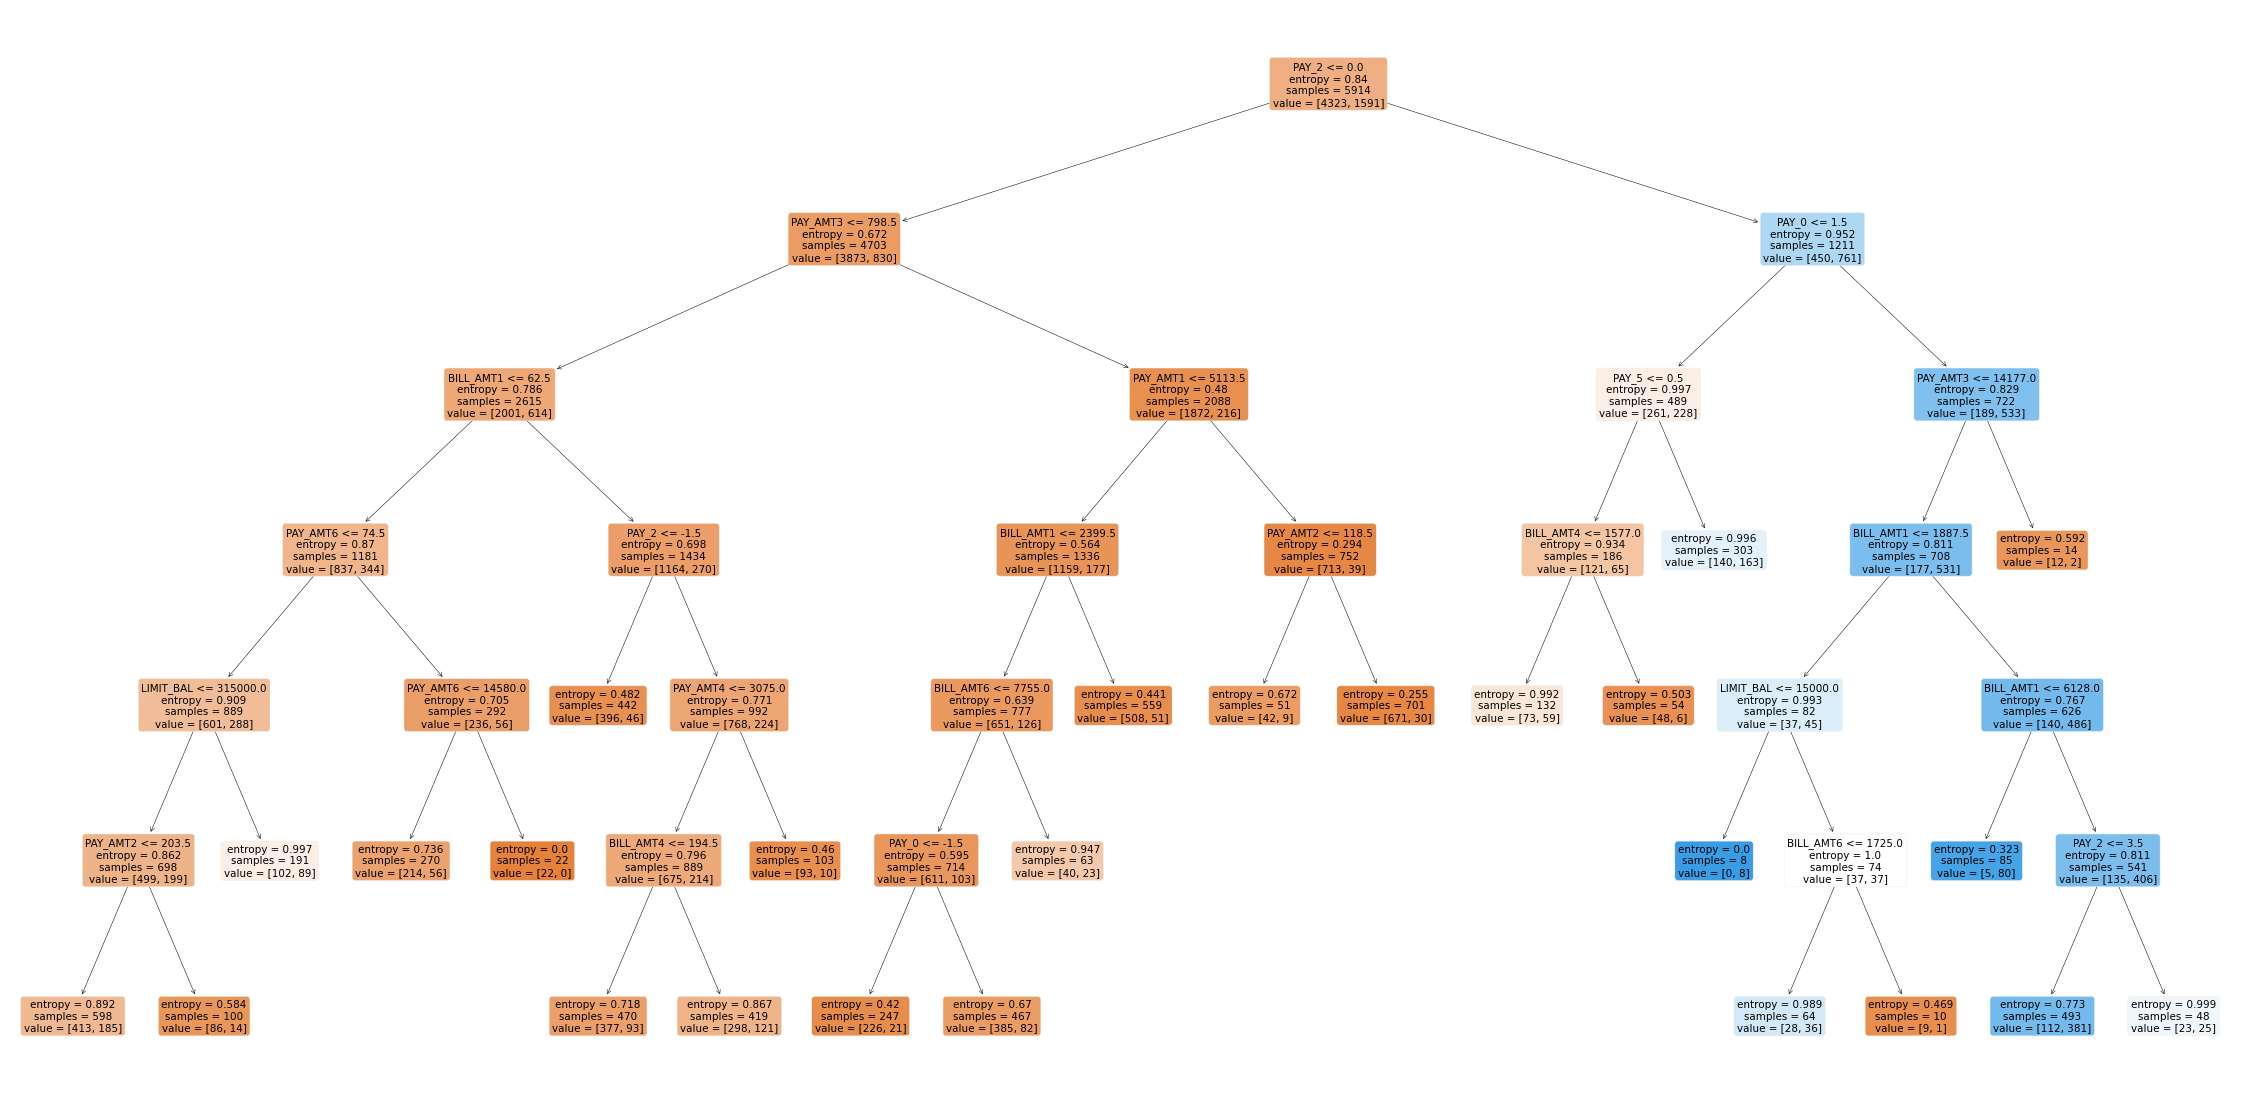

In [18]:
# Построю изображение дерева при помощи sklearn и matplotlib

plt.figure(figsize=(40,20)) 
_ = tree.plot_tree(model, feature_names=df.iloc[:, :-1].columns, filled=True, rounded = True)
plt.show()

**Промежуточные выводы:**
- Показатели Accuracy говорят о том, что переобучения нет. 
- На графике дерева большинство узлов загрязняны (entropy > 0).
- Попробую изменить глубину дерева (max_depth), минимальное число в узле-родителе (min_samples_split), минимальное число в узле-потомке (min_samples_leaf).

In [19]:
print(metrics.classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2406
           1       0.44      0.69      0.54       507

    accuracy                           0.79      2913
   macro avg       0.68      0.75      0.70      2913
weighted avg       0.84      0.79      0.81      2913



В метриках качества посмотрим на взвешенное среднее по классам для precision, recall, f1-score, так как число экземпляров в наших классах отличается.

In [20]:
print(metrics.precision_recall_fscore_support(y_pred_test, y_test, average='weighted'))

(0.8421945954718877, 0.7936834878132509, 0.8100466789009925, None)


Теперь построю сетку параметров модели GridSearch, чтобы автоматизировать их подбор.

In [21]:
# Инициализирую модель

model_2 = DecisionTreeClassifier(random_state=42,
                                 criterion='entropy',
                                 # максимальная глубина дерева
                                 max_depth=6,
                                 max_leaf_nodes=None,
                                 # минимальное число элементов в узле для разбиения (может быть долей)
                                 min_samples_split=10,
                                 # минимальное число элементов в листе (может быть долей)
                                 min_samples_leaf=8,
                                 min_impurity_decrease=0.001,
                                 class_weight=None,
                                 min_weight_fraction_leaf=0,                               
                                 splitter='best',
                                 max_features = None)

In [22]:
#  Определяю интересные значения гиперпараметров

params_set = {
'criterion': ['gini', 'entropy'],
'max_depth': [4, 6, 8],
'min_samples_leaf': [2, 4, 6, 8, 10],
'min_samples_split': [10, 12, 14, 16]
}


#  Провожу 5-fold кросс-валидацию
#  Качество моделей сравниваю с помощью accuracy

grid_CV_1 = GridSearchCV(estimator=model_2,
       param_grid=params_set,
       scoring='accuracy',
       cv=5,
       n_jobs=-1)


#  Обучение на обучающей выборке

grid_CV_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                              min_impurity_decrease=0.001,
                                              min_samples_leaf=8,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'min_samples_leaf': [2, 4, 6, 8, 10],
                         'min_samples_split': [10, 12, 14, 16]},
             scoring='accuracy')

In [23]:
#  Лучший набор значений гиперпараметров

best_hyperparams = grid_CV_1.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

Лучшие значения гиперпараметров:
 {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [24]:
# Значение критерия качества для лучших значений гиперпараметров

best_CV_score = grid_CV_1.best_score_
print('Лучшее accuracy', best_CV_score)

Лучшее accuracy 0.7886399686477781


In [25]:
# Лучшая модель

best_model = grid_CV_1.best_estimator_

# accuracy на тестовом множестве для лучшей модели

test_acc = best_model.score(X_test,y_test)

# Значение критерия качества для лучших значений гиперпараметров

print('Лучшее accuracy на тестовом множестве', test_acc)

Лучшее accuracy на тестовом множестве 0.7936834878132509


In [26]:
means = grid_CV_1.cv_results_['mean_test_score']
stds  = grid_CV_1.cv_results_['std_test_score']

In [27]:
for mean, std, params in zip(means, stds, grid_CV_1.cv_results_['params']):
    print("%0.4f (+/-%0.03f) for %r"  % (mean, std * 2, params))
print()

0.7863 (+/-0.023) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.7863 (+/-0.023) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 12}
0.7863 (+/-0.023) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 14}
0.7863 (+/-0.023) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 16}
0.7863 (+/-0.023) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10}
0.7863 (+/-0.023) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 12}
0.7863 (+/-0.023) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 14}
0.7863 (+/-0.023) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 16}
0.7859 (+/-0.023) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 10}
0.7859 (+/-0.023) for {'crit

В нашем случае лучшее значение accuracy 0,7886 достигается при 20 наборах значений. Указанный набор является лишь первым в списке, при котором достигается лучшее значение.

**Вывод:**
- Повысить accuracy модели за счет изменения гиперпараметров не удалось.
- Модель не переобучается.
- В итоге accuracy на обучающей выборке равна 78,86%. На тренировочной - 79,37%, что лучше на 6% распознавания методом k-го ближайшего соседа.